In [1]:
# load packages
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
tf.__version__

'1.12.0'

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Classifying newswires: a multi-class classification example

---- 

Here, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [3]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) # num_words - take only most frequent words

In [4]:
# number of train and test samples
len(train_data), len(test_data)

(8982, 2246)

In [5]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [6]:
# get word index mapping
word_index = reuters.get_word_index()

# get index to word mapping
# indices were offset by 3 to accomodate padding, start and unkown tokens
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [7]:
# get the real news data using this reverse index
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [8]:
train_labels[10]

3

## Preparing the data

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# vectorized training data
x_train = vectorize_sequences(train_data)

# vectorized test data
x_test = vectorize_sequences(test_data)

In [10]:
x_train[0], x_train[10]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]))

In [11]:
x_test[0], x_test[10]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]))

In [12]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)

# vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

In [13]:
x_train[0], x_train[10]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]))

In [14]:
x_test[0], x_test[10]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]))

You can do the same using the built-in method.

In [15]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [16]:
one_hot_train_labels[0], one_hot_train_labels[10]

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [17]:
one_hot_test_labels[0], one_hot_test_labels[10]

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## Building Model

In [18]:
from tensorflow.keras import models, layers

# mdoel architecture
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

In [19]:
# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Validating our approach

In [20]:
# split train data into train and validate set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [21]:
# train model for 20 epochs
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 241us/step - loss: 2.5469 - acc: 0.5430 - val_loss: 1.6961 - val_acc: 0.6560
Epoch 2/20
7982/7982 [==============================] - 1s 99us/step - loss: 1.3890 - acc: 0.7191 - val_loss: 1.3131 - val_acc: 0.7170
Epoch 3/20
7982/7982 [==============================] - 1s 104us/step - loss: 1.0399 - acc: 0.7809 - val_loss: 1.1380 - val_acc: 0.7760
Epoch 4/20
7982/7982 [==============================] - 1s 104us/step - loss: 0.8257 - acc: 0.8291 - val_loss: 1.0385 - val_acc: 0.7910
Epoch 5/20
7982/7982 [==============================] - 1s 105us/step - loss: 0.6607 - acc: 0.8589 - val_loss: 0.9867 - val_acc: 0.7960
Epoch 6/20
7982/7982 [==============================] - 1s 100us/step - loss: 0.5328 - acc: 0.8870 - val_loss: 0.9429 - val_acc: 0.8140
Epoch 7/20
7982/7982 [==============================] - 1s 100us/step - loss: 0.4307 - acc: 0.9102 - val_loss: 0.9188 - val_acc: 0.8170
E

## Visualize Model Performance

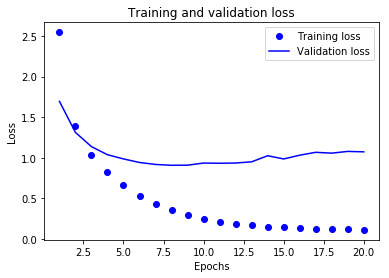

In [22]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

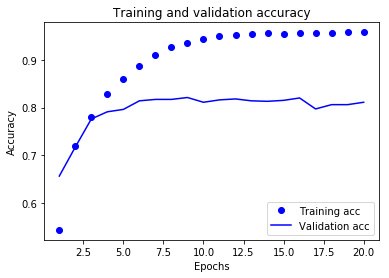

In [23]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [24]:
# re-initiate the model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# train model
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 218us/step - loss: 2.6586 - acc: 0.5237 - val_loss: 1.7857 - val_acc: 0.6220
Epoch 2/8
7982/7982 [==============================] - 1s 108us/step - loss: 1.4620 - acc: 0.6863 - val_loss: 1.3399 - val_acc: 0.6980
Epoch 3/8
7982/7982 [==============================] - 1s 111us/step - loss: 1.0733 - acc: 0.7662 - val_loss: 1.1467 - val_acc: 0.7490
Epoch 4/8
7982/7982 [==============================] - 1s 106us/step - loss: 0.8519 - acc: 0.8127 - val_loss: 1.0555 - val_acc: 0.7840
Epoch 5/8
7982/7982 [==============================] - 1s 106us/step - loss: 0.6721 - acc: 0.8557 - val_loss: 0.9829 - val_acc: 0.7990
Epoch 6/8
7982/7982 [==============================] - 1s 104us/step - loss: 0.5433 - acc: 0.8862 - val_loss: 0.9483 - val_acc: 0.8020
Epoch 7/8
7982/7982 [==============================] - 1s 104us/step - loss: 0.4386 - acc: 0.9082 - val_loss: 0.9074 - val_acc: 0.8130
Epoch 8

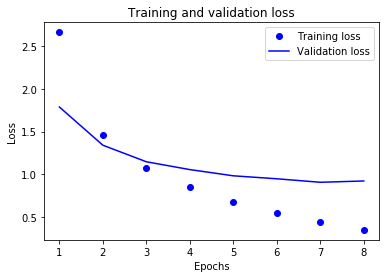

In [25]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

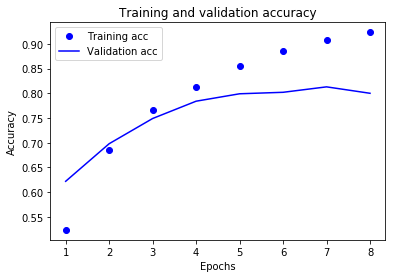

In [26]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [27]:
# evaluate on test set
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 0s 106us/step


[1.003387930556694, 0.7827248441939468]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline.

## Generating predictions on new data

In [28]:
predictions = model.predict(x_test)

In [29]:
predictions[0].shape

(46,)

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [30]:
# re-initiate model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# train model
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 213us/step - loss: 3.6247 - acc: 0.0742 - val_loss: 3.3911 - val_acc: 0.2530
Epoch 2/8
7982/7982 [==============================] - 1s 101us/step - loss: 3.1788 - acc: 0.2702 - val_loss: 3.0501 - val_acc: 0.2850
Epoch 3/8
7982/7982 [==============================] - 1s 100us/step - loss: 2.8477 - acc: 0.3068 - val_loss: 2.8343 - val_acc: 0.2930
Epoch 4/8
7982/7982 [==============================] - 1s 100us/step - loss: 2.6038 - acc: 0.3171 - val_loss: 2.6593 - val_acc: 0.2940
Epoch 5/8
7982/7982 [==============================] - 1s 99us/step - loss: 2.4047 - acc: 0.3239 - val_loss: 2.5248 - val_acc: 0.2980
Epoch 6/8
7982/7982 [==============================] - 1s 99us/step - loss: 2.2251 - acc: 0.3388 - val_loss: 2.3930 - val_acc: 0.3120
Epoch 7/8
7982/7982 [==============================] - 1s 103us/step - loss: 2.0459 - acc: 0.3540 - val_loss: 2.2516 - val_acc: 0.3240
Epoch 8/8

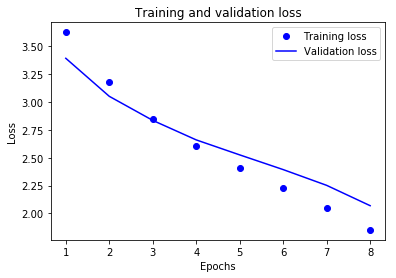

In [31]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

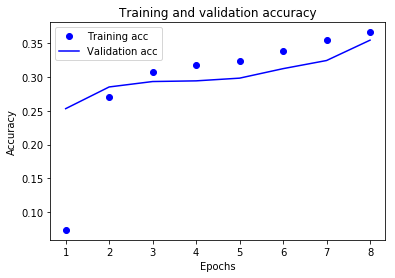

In [32]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


Our network now seems to peak at ~65% test accuracy. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional.